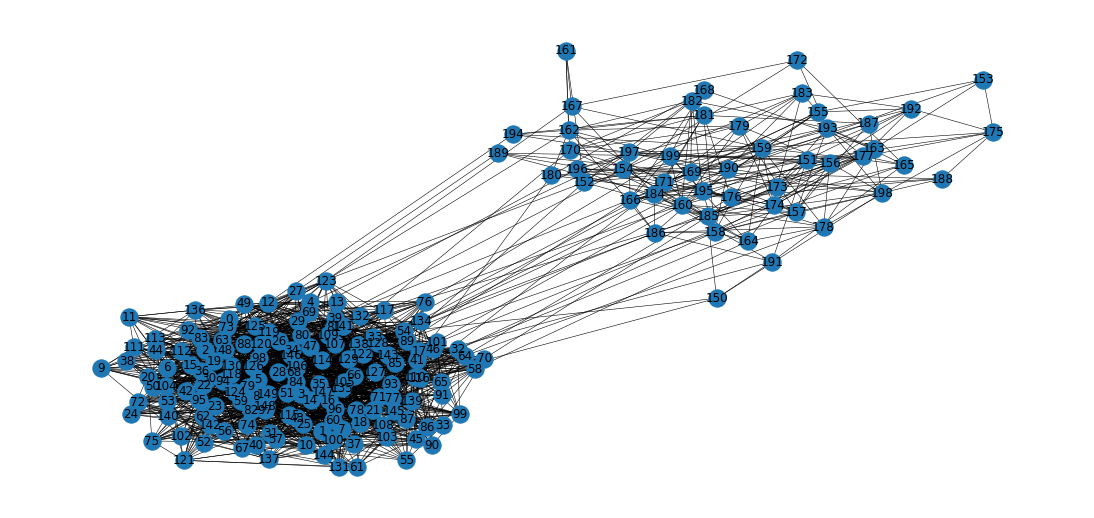

torch.Size([200, 200])


In [26]:
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
import warnings 
warnings.filterwarnings("ignore")
# Let's create a stochastic block model
sizes = [150, 50]

probs = [[0.15, 0.005],
         [0.005, 0.15]]
         

G = nx.stochastic_block_model(sizes, probs, seed=0)
#Let's color the nodes with the same color of the block
pos = nx.spring_layout(G,seed=1234567)
plt.figure(figsize=(15,7))
#draw nodes with mapped color
nx.draw(G,
        pos=pos,
        edge_color='black',
        width=0.55,
        style='solid',
        linewidths=1,
        cmap=plt.cm.viridis,
        #node_size=100,
        with_labels=True,
        alpha=1,
        )

plt.show()
# Get the adjacency matrix
adj = nx.adjacency_matrix(G)
adj = torch.tensor(adj.todense()).float()
print(adj.shape)

In [27]:
import torch
import warnings
warnings.filterwarnings('ignore')
from sklearn.cluster import SpectralClustering
from sklearn.cluster import KMeans
from torch_geometric.utils import to_dense_adj
from torch_geometric.utils import to_networkx
from torch_geometric.datasets import Planetoid, WebKB, WikipediaNetwork,Actor,LINKXDataset
import networkx as nx
import numpy as np
np.random.seed(1234)
torch.manual_seed(12345)
def spectral_cluster(graph, num_clusters):
    normalized_laplacian_matrix = nx.normalized_laplacian_matrix(graph).todense()
    eigvals, eigvecs = np.linalg.eig(normalized_laplacian_matrix)
    eigvals = np.real(eigvals)
    eigvecs = np.real(eigvecs)
    #print(eigvals)
    #print(eigvecs)
    indices = np.argsort(eigvals)[:num_clusters]
    k_smallest_eigvecs = eigvecs[:, indices]
    clustering = KMeans(n_clusters=num_clusters).fit(k_smallest_eigvecs)
    cluster_assignments = clustering.labels_
    return list(cluster_assignments)

def structural_heterophily(data,num_classes=5):
    G = to_networkx(data, to_undirected=True)    
    # Get the largest connected component
    #Gcc = sorted(nx.connected_components(G), key=len, reverse=True)
    #G = G.subgraph(Gcc[0])
    # data.y will contain the labels only of the largest connected component
    selected_nodes = list(G.nodes)
    #data.y = data.y[selected_nodes]
    laplacian = nx.normalized_laplacian_matrix(G)
    laplacian = laplacian.todense()
    # to tensor
    laplacian = torch.tensor(laplacian,dtype=torch.float32)
    data.y = torch.tensor(data.y.numpy(),dtype=torch.float32)
    # Let's compute data.y^T @ L @ data.y
    num = torch.matmul(torch.matmul(data.y,laplacian),data.y)
    # Let's compute sc.labels_^T @ L @ sc.labels_
    sc = spectral_cluster(G,num_classes)
    sc = torch.tensor(sc,dtype=torch.float32)
    den = torch.matmul(torch.matmul(sc,laplacian),sc)
    return round((num/den).item(),3)
#dataset = WebKB(root='./', name='Cornell')
#dataset = Planetoid(root='/tmp/Cora', name='Pubmed')
#dataset = WikipediaNetwork(root='./',name = 'Squirrel')
#dataset = Actor(root='./')
#dataset = LINKXDataset(root='./data',name='penn94')
#print(dataset)
#print(dataset[0])
#data = dataset[0]

#print(structural_heterophily(data,num_classes=data.y.max().item()+1))

In [28]:
#Let's save the degree of each node in a torch tensor
from torch_geometric.utils import to_dense_adj
print(len(G.nodes()))
degrees = torch.tensor([G.degree(node) for node in G.nodes()],dtype=torch.float32).reshape(-1,1)
#Parse the graph to a torch_geometric.data.Data object
from torch_geometric.utils import from_networkx
print(G)
A = G
C = nx.Graph()
C.add_nodes_from(A.nodes())
C.add_edges_from(A.edges())
data = from_networkx(C)
print(data)
data.x = to_dense_adj(data.edge_index)[0] #Adj 
data.y = torch.tensor([0,0,0,1,1,2,2,2,2]).reshape(-1,1)
data.edge_index = adj.nonzero().t()
L_normalized = torch.Tensor(nx.normalized_laplacian_matrix(C).todense())
print(L_normalized.shape)
print(data)
from sklearn.model_selection import train_test_split
def rand_train_test_idx(label, train_prop=.5, valid_prop=.25, ignore_negative=True,seed=1234):
      
      """ randomly splits label into train/valid/test splits """
      train_idx, test_idx = train_test_split(np.arange(len(label)), train_size=train_prop, random_state=seed)
      val_idx, test_idx = train_test_split(test_idx, train_size=train_prop, random_state=seed)
      train_mask = torch.zeros(len(label), dtype=torch.bool)
      train_mask[train_idx] = True
      val_mask = torch.zeros(len(label), dtype=torch.bool)
      val_mask[val_idx] = True
      test_mask = torch.zeros(len(label), dtype=torch.bool)
      test_mask[test_idx] = True
      return train_mask, val_mask, test_mask

200
Graph named 'stochastic_block_model' with 200 nodes and 1899 edges
Data(edge_index=[2, 3798], num_nodes=200)
torch.Size([200, 200])
Data(edge_index=[2, 3798], num_nodes=200, x=[200, 200], y=[9, 1])


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Data(x=[3327, 3703], edge_index=[2, 9104], y=[3327], train_mask=[3327], val_mask=[3327], test_mask=[3327])
Number of classes:  6
Number of nodes of class 0:  150
Number of nodes of class 1:  50
Data(edge_index=[2, 3798], num_nodes=200, x=[200, 1], y=[200, 1])


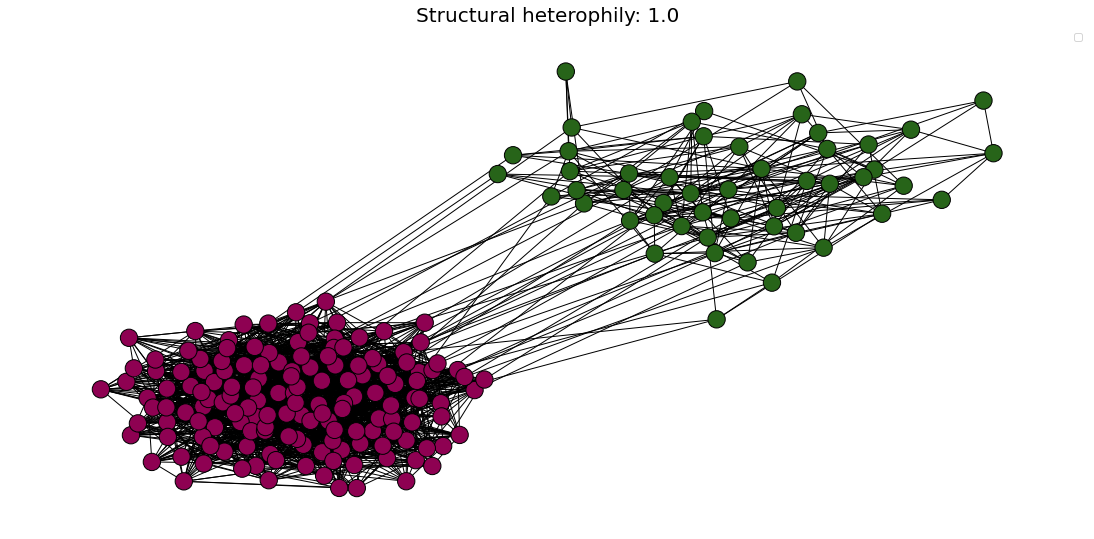

In [29]:
# Let's add the features and the labels of the citeseer dataset
datas = []
import torch
import networkx as nx
from torch_geometric.utils import to_dense_adj
from torch_geometric.datasets import Planetoid
from torch_geometric.utils import homophily
import numpy as np
import matplotlib.pyplot as plt
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Let's add the features and the labels of the citeseer dataset
from torch_geometric.datasets import Planetoid, WikipediaNetwork
from torch_geometric.utils import homophily
dataset = Planetoid(root='./data', name='citeseer')
#dataset = WikipediaNetwork(root='./data', name='squirrel')
data_citeseer = dataset[0]
print(data_citeseer)
print("Number of classes: ", dataset.num_classes)
# Let's choose 35 nodes from each class of citeseer
labels_of_class_0 = data_citeseer.y == 0
#features_of_class_0 = data_citeseer.x[labels_of_class_0]
features_of_class_0 = torch.zeros(data_citeseer.x.shape[0])
features_of_class_0 = features_of_class_0 + torch.tensor(np.random.normal(0,0.5,data_citeseer.x.shape[0]))
features_of_class_0 = features_of_class_0.unsqueeze(1)
labels_of_class_1 = data_citeseer.y == 1
# Place a -1 in the features of class 1
features_of_class_1 = torch.ones(data_citeseer.x.shape[0])*-1
features_of_class_1 = features_of_class_1 + torch.tensor(np.random.normal(0,0.5,data_citeseer.x.shape[0]))

features_of_class_1 = features_of_class_1.unsqueeze(1)
data.x = torch.cat((features_of_class_0[:150],features_of_class_1[150:200]),dim=0)
data.y = torch.cat((torch.zeros(150),torch.ones(50)),dim=0).reshape(-1,1)
# Let's permutate the nodes
print("Number of nodes of class 0: ",len(data.y[data.y==0]))
print("Number of nodes of class 1: ",len(data.y[data.y==1]))
# Let's create the train and test mask

train_mask, val_mask, test_mask = rand_train_test_idx(data.y,seed=1234)
print(data)
# PLot the graph
plt.figure(figsize=(15,7))
nx.draw(G,
        pos=pos,
        node_color= data.y,
        edge_color='black',
        width=1,
        style='solid',
        linewidths=1,
        cmap=plt.cm.PiYG,
        #node_size=100,
        with_labels=False,
        alpha=1,
        edgecolors='black'
        
        )
homofilia = homophily( data.edge_index, data.y, method='node')
#plt.title(f'Homophily: {homofilia:.3f}', fontsize=20)
data.y = data.y.squeeze(1)
plt.legend()
sh = structural_heterophily(data,num_classes=2)
plt.title("Structural heterophily: "+str(sh), fontsize=20)      
plt.show()
datas.append(data.clone())

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Data(x=[3327, 3703], edge_index=[2, 9104], y=[3327], train_mask=[3327], val_mask=[3327], test_mask=[3327])
Number of classes:  6
Number of nodes of class 0:  150
Number of nodes of class 1:  50
Data(edge_index=[2, 3798], num_nodes=200, x=[200, 1], y=[200, 1])


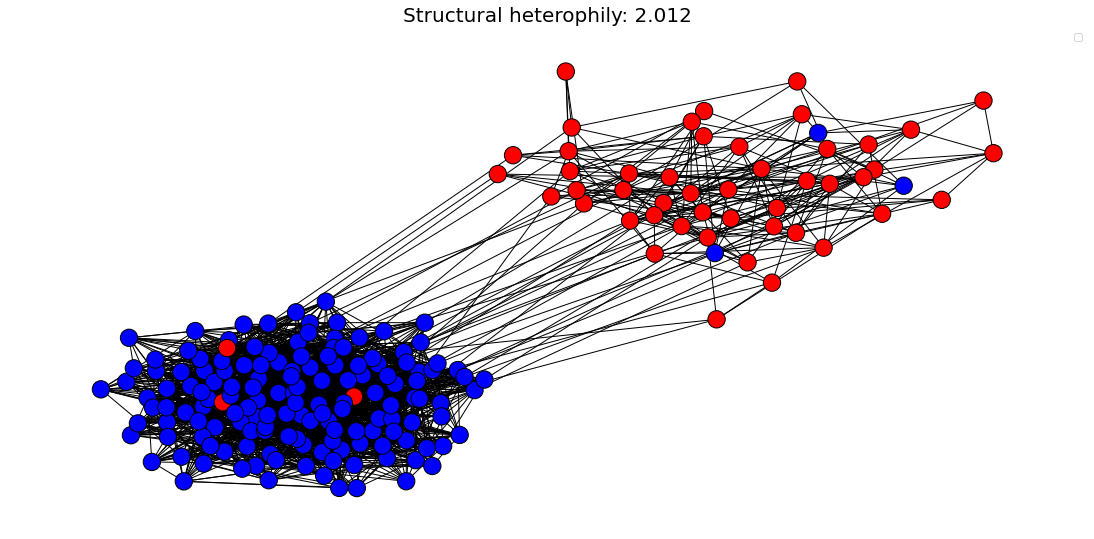

In [30]:
dataset = Planetoid(root='./data', name='citeseer')
#dataset = WikipediaNetwork(root='./data', name='squirrel')
data_citeseer = dataset[0]
print(data_citeseer)
print("Number of classes: ", dataset.num_classes)
labels_of_class_0 = data_citeseer.y == 0
#features_of_class_0 = data_citeseer.x[labels_of_class_0]
features_of_class_0 = torch.zeros(data_citeseer.x.shape[0])
features_of_class_0 = features_of_class_0 + torch.tensor(np.random.normal(0,0.5,data_citeseer.x.shape[0]))
features_of_class_0 = features_of_class_0.unsqueeze(1)
labels_of_class_1 = data_citeseer.y == 1
# Place a -1 in the features of class 1
features_of_class_1 = torch.ones(data_citeseer.x.shape[0])*-1
features_of_class_1 = features_of_class_1 + torch.tensor(np.random.normal(0,0.5,data_citeseer.x.shape[0]))
features_of_class_1 = features_of_class_1.unsqueeze(1)
data.x = torch.cat((features_of_class_0[:150],features_of_class_1[150:200]),dim=0)
data.y = torch.cat((torch.zeros(150),torch.ones(50)),dim=0).reshape(-1,1)
data.x[12:15] = features_of_class_1[12:15]
data.y[12:15] = torch.ones(3).reshape(-1,1)
data.x[158:161] = features_of_class_0[158:161]
data.y[158:161] = torch.zeros(3).reshape(-1,1)
# let's permutate the nodes
perm = torch.randperm(150)
data.x[:150] = data.x[perm]
data.y[:150] = data.y[perm]
perm = torch.randperm(50)
data.x[150:] = data.x[150+perm]
data.y[150:] = data.y[150+perm]
# Let's permutate the nodes
print("Number of nodes of class 0: ",len(data.y[data.y==0]))
print("Number of nodes of class 1: ",len(data.y[data.y==1]))
# Let's create the train and test mask

train_mask, val_mask, test_mask = rand_train_test_idx(data.y,seed=1234)
print(data)
# PLot the graph
plt.figure(figsize=(15,7))
nx.draw(G,
        pos=pos,
        node_color= data.y,
        edge_color='black',
        width=1,
        style='solid',
        linewidths=1,
        cmap=plt.cm.bwr,
        #node_size=100,
        with_labels=False,
        alpha=1,
        edgecolors='black'
        
        )
homofilia = homophily( data.edge_index, data.y, method='node')
#plt.title(f'Homophily: {homofilia:.3f}', fontsize=20)
data.y = data.y.squeeze(1)
plt.legend()
sh = structural_heterophily(data,num_classes=2)
plt.title("Structural heterophily: "+str(sh), fontsize=20)      
plt.show()
datas.append(data.clone())

In [31]:
dataset = Planetoid(root='./data', name='citeseer')
#dataset = WikipediaNetwork(root='./data', name='squirrel')
data_citeseer = dataset[0]
print(data_citeseer)
print("Number of classes: ", dataset.num_classes)
# Let's choose 35 nodes from each class of citeseer
labels_of_class_0 = data_citeseer.y == 0
#features_of_class_0 = data_citeseer.x[labels_of_class_0]
features_of_class_0 = torch.zeros(data_citeseer.x.shape[0])
features_of_class_0 = features_of_class_0 + torch.tensor(np.random.normal(0,0.5,data_citeseer.x.shape[0]))
features_of_class_0 = features_of_class_0.unsqueeze(1)
labels_of_class_1 = data_citeseer.y == 1
# Place a -1 in the features of class 1
features_of_class_1 = torch.ones(data_citeseer.x.shape[0])*-1
features_of_class_1 = features_of_class_1 + torch.tensor(np.random.normal(0,0.5,data_citeseer.x.shape[0]))
features_of_class_1 = features_of_class_1.unsqueeze(1)
data.x = torch.cat((features_of_class_0[:150],features_of_class_1[150:200]),dim=0)
data.y = torch.cat((torch.zeros(150),torch.ones(50)),dim=0).reshape(-1,1)
data.x[12:24] = features_of_class_1[12:24]
data.y[12:24] = torch.ones(12).reshape(-1,1)
data.x[158:163] = features_of_class_0[158:163]
data.y[158:163] = torch.zeros(5).reshape(-1,1)
# let's permutate the nodes
perm = torch.randperm(150)
data.x[:150] = data.x[perm]
data.y[:150] = data.y[perm]
perm = torch.randperm(50)
data.x[150:] = data.x[150+perm]
data.y[150:] = data.y[150+perm]
# Let's permutate the nodes
print("Number of nodes of class 0: ",len(data.y[data.y==0]))
print("Number of nodes of class 1: ",len(data.y[data.y==1]))
# Let's create the train and test mask

train_mask, val_mask, test_mask = rand_train_test_idx(data.y,seed=1234)
print(data)
# PLot the graph
plt.figure(figsize=(15,7))
nx.draw(G,
        pos=pos,
        node_color= data.y,
        edge_color='black',
        width=1,
        style='solid',
        linewidths=1,
        cmap=plt.cm.bwr,
        #node_size=100,
        with_labels=False,
        alpha=1,
        edgecolors='black'
        
        )
homofilia = homophily( data.edge_index, data.y, method='node')
#plt.title(f'Homophily: {homofilia:.3f}', fontsize=20)
data.y = data.y.squeeze(1)
plt.legend()
sh = structural_heterophily(data,num_classes=2)
plt.title("Structural heterophily: "+str(sh), fontsize=20)      
plt.show()
datas.append(data.clone())

Data(x=[3327, 3703], edge_index=[2, 9104], y=[3327], train_mask=[3327], val_mask=[3327], test_mask=[3327])
Number of classes:  6


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Number of nodes of class 0:  143
Number of nodes of class 1:  57
Data(edge_index=[2, 3798], num_nodes=200, x=[200, 1], y=[200, 1])


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Data(x=[3327, 3703], edge_index=[2, 9104], y=[3327], train_mask=[3327], val_mask=[3327], test_mask=[3327])
Number of classes:  6
Number of nodes of class 0:  142
Number of nodes of class 1:  58
Data(edge_index=[2, 3798], num_nodes=200, x=[200, 1], y=[200, 1])


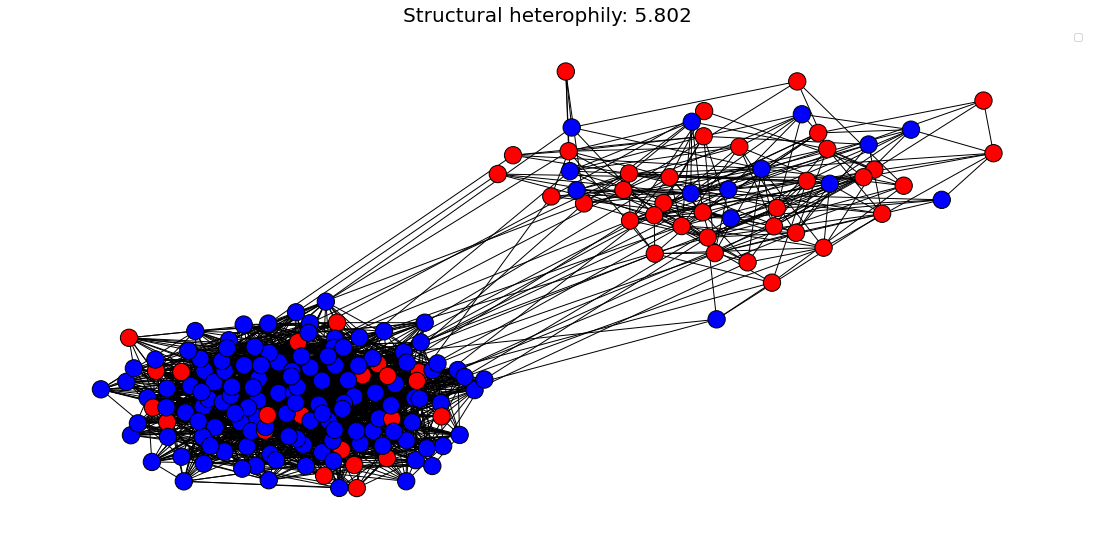

In [32]:
dataset = Planetoid(root='./data', name='citeseer')
#dataset = WikipediaNetwork(root='./data', name='squirrel')
data_citeseer = dataset[0]
print(data_citeseer)
print("Number of classes: ", dataset.num_classes)
# Let's choose 35 nodes from each class of citeseer
labels_of_class_0 = data_citeseer.y == 0
#features_of_class_0 = data_citeseer.x[labels_of_class_0]
features_of_class_0 = torch.zeros(data_citeseer.x.shape[0])
features_of_class_0 = features_of_class_0 + torch.tensor(np.random.normal(0,0.5,data_citeseer.x.shape[0]))
features_of_class_0 = features_of_class_0.unsqueeze(1)
labels_of_class_1 = data_citeseer.y == 1
# Place a -1 in the features of class 1
features_of_class_1 = torch.ones(data_citeseer.x.shape[0])*-1
features_of_class_1 = features_of_class_1 + torch.tensor(np.random.normal(0,0.5,data_citeseer.x.shape[0]))
features_of_class_1 = features_of_class_1.unsqueeze(1)
data.x = torch.cat((features_of_class_0[:150],features_of_class_1[150:200]),dim=0)
data.y = torch.cat((torch.zeros(150),torch.ones(50)),dim=0).reshape(-1,1)
data.x[12:34] = features_of_class_1[12:34]
data.y[12:34] = torch.ones(22).reshape(-1,1)
data.x[150:164] = features_of_class_0[150:164]
data.y[150:164] = torch.zeros(14).reshape(-1,1)
# let's permutate the nodes
perm = torch.randperm(150)
data.x[:150] = data.x[perm]
data.y[:150] = data.y[perm]
perm = torch.randperm(50)
data.x[150:] = data.x[150+perm]
data.y[150:] = data.y[150+perm]
# Let's permutate the nodes
print("Number of nodes of class 0: ",len(data.y[data.y==0]))
print("Number of nodes of class 1: ",len(data.y[data.y==1]))
# Let's create the train and test mask

train_mask, val_mask, test_mask = rand_train_test_idx(data.y,seed=1234)
print(data)
# PLot the graph
plt.figure(figsize=(15,7))
nx.draw(G,
        pos=pos,
        node_color= data.y,
        edge_color='black',
        width=1,
        style='solid',
        linewidths=1,
        cmap=plt.cm.bwr,
        #node_size=100,
        with_labels=False,
        alpha=1,
        edgecolors='black'
        
        )
homofilia = homophily( data.edge_index, data.y, method='node')
#plt.title(f'Homophily: {homofilia:.3f}', fontsize=20)
data.y = data.y.squeeze(1)
plt.legend()
sh = structural_heterophily(data,num_classes=2)
plt.title("Structural heterophily: "+str(sh), fontsize=20)      
plt.show()
datas.append(data.clone())

Data(x=[3327, 3703], edge_index=[2, 9104], y=[3327], train_mask=[3327], val_mask=[3327], test_mask=[3327])
Number of classes:  6
Number of nodes of class 0:  100
Number of nodes of class 1:  100
Data(edge_index=[2, 3798], num_nodes=200, x=[200, 1], y=[200, 1])


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


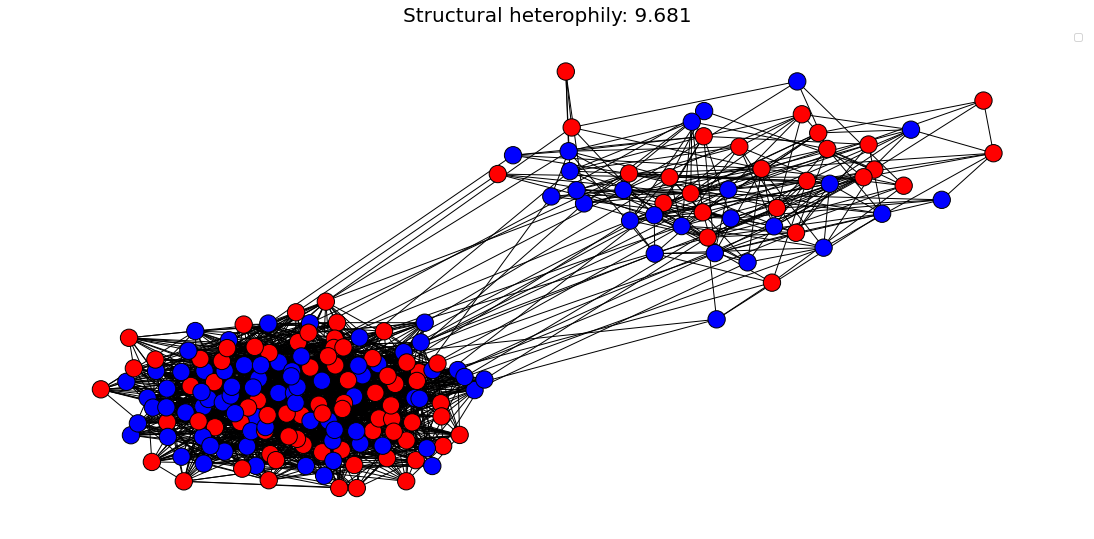

In [33]:
dataset = Planetoid(root='./data', name='citeseer')
#dataset = WikipediaNetwork(root='./data', name='squirrel')
data_citeseer = dataset[0]
print(data_citeseer)
print("Number of classes: ", dataset.num_classes)
# Let's choose 35 nodes from each class of citeseer
labels_of_class_0 = data_citeseer.y == 0
#features_of_class_0 = data_citeseer.x[labels_of_class_0]
features_of_class_0 = torch.zeros(data_citeseer.x.shape[0])
features_of_class_0 = features_of_class_0 + torch.tensor(np.random.normal(0,0.5,data_citeseer.x.shape[0]))
features_of_class_0 = features_of_class_0.unsqueeze(1)
labels_of_class_1 = data_citeseer.y == 1
# Place a -1 in the features of class 1
features_of_class_1 = torch.ones(data_citeseer.x.shape[0])*-1
features_of_class_1 = features_of_class_1 + torch.tensor(np.random.normal(0,0.5,data_citeseer.x.shape[0]))
features_of_class_1 = features_of_class_1.unsqueeze(1)
data.x = features_of_class_0[:200]
data.y = torch.zeros(200).unsqueeze(1)
# Let's intercalate the nodes with a random permutation with see
for i in range(data.x.shape[0]):
    if i%2==1:
        data.y[i] = 1
        data.x[i] = features_of_class_1[i]
# Now add a random permutation
perm = torch.randperm(200)
#data.x = data.x[perm]
#data.y = data.y[perm]
print("Number of nodes of class 0: ",len(data.y[data.y==0]))
print("Number of nodes of class 1: ",len(data.y[data.y==1]))
# Let's create the train and test mask

train_mask, val_mask, test_mask = rand_train_test_idx(data.y,seed=1234)
print(data)
# PLot the graph
plt.figure(figsize=(15,7))
nx.draw(G,
        pos=pos,
        node_color= data.y,
        edge_color='black',
        width=1,
        style='solid',
        linewidths=1,
        cmap=plt.cm.bwr,
        #node_size=100,
        with_labels=False,
        alpha=1,
        edgecolors='black'
        
        )
homofilia = homophily( data.edge_index, data.y, method='node')
#plt.title(f'Homophily: {homofilia:.3f}', fontsize=20)
data.y = data.y.squeeze(1)
plt.legend()
sh = structural_heterophily(data,num_classes=2)
plt.title("Structural heterophily: "+str(sh), fontsize=20)      
plt.show()
datas.append(data.clone())

In [34]:
print(len(datas))

5


In [35]:
import torch
# Trace of a tensor [1,k,k]
def _rank3_trace(x):
    return torch.einsum('ijj->i', x)

# Diagonal version of a tensor [1,n] -> [1,n,n]
def _rank3_diag(x):
    eye = torch.eye(x.size(1)).type_as(x)
    out = eye * x.unsqueeze(2).expand(*x.size(), x.size(1)) 
    return out

def pump(adj, s): 
    adj = adj.unsqueeze(0) if adj.dim() == 2 else adj # adj torch.Size([20, N, N]) N=Mmax
    s = s.unsqueeze(0) if s.dim() == 2 else s # s torch.Size([20, N, k])
    k = s.size(-1)
    s = torch.tanh(s) # torch.Size([20, N, k]) One k for each N of each graph
    d_flat = torch.einsum('ijk->ij', adj) # torch.Size([20, N]) 
    d = _rank3_diag(d_flat) # d torch.Size([20, N, N]) 
    
    CT_num = _rank3_trace(torch.matmul(torch.matmul(s.transpose(1, 2),adj), s)) # Tr(S^T A S) 
    CT_den = _rank3_trace(torch.matmul(torch.matmul(s.transpose(1, 2), d), s))  # Tr(S^T D S) 
    adj = torch.cdist(s,s,p=2) # Distance matrix
    vol = _rank3_trace(d) # Vol(G)
    adj = (adj) / vol.unsqueeze(1).unsqueeze(1) # Distance matrix normalized
    # Mask with adjacency if proceeds 
    CT_loss = -(CT_num / CT_den) # Tr(S^T A S) / Tr(S^T D S)
    CT_loss = torch.mean(CT_loss)
    
    # Orthogonality regularization.
    ss = torch.matmul(s.transpose(1, 2), s)  
    i_s = torch.eye(k).type_as(ss) 
    ortho_loss = torch.norm(
        ss / torch.norm(ss, dim=(-1, -2), keepdim=True) -
        i_s )  
    ortho_loss = torch.mean(ortho_loss)
    del d
    del vol
    del d_flat
    return s, CT_loss, ortho_loss,adj 

In [36]:
from torch_geometric.nn import GCNConv,DenseGCNConv
from torch.nn import Linear
import torch.nn.functional as F

class ODwire(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels,num_centers,adj_dim, n_layers,out_channels,drop_out = 0.5):
        super(ODwire, self).__init__()
        torch.manual_seed(1234)
        # CT-Layer
        #self.eiguen = torch.nn.Parameter(torch.ones(adj_dim, num_centers))
        self.MLP = Linear(adj_dim, num_centers)#Texas 4 # X -> S
        #GNN
        # We are going to create a list of layers of the GNN
        self.convs = torch.nn.ModuleList()
        for i in range(n_layers):
            self.convs.append(DenseGCNConv(in_channels, hidden_channels))
        #Aux
        self.drop_out = drop_out
        self.new_adj = None
        self.embeddings = None
        self.gnn_out = None
        self.loss = None
        # Parameters
        self.att = torch.nn.Parameter(torch.ones(n_layers))
        #self.att = torch.nn.Parameter(torch.ones(n_layers))
        self.sm = torch.nn.Softmax(dim=0)
        # Linear
        #self.classify1 = Linear(hidden_channels*(n_layers + 1), out_channels)
        self.classify1 = Linear(hidden_channels*(n_layers), out_channels)
        self.tsne = None
    def forward(self, x, adj):
        #self.MLP.weight.requires_grad = True
        #self.MLP.bias.requires_grad = True
        mask_attentions = self.sm(self.att)
        
        s = self.MLP(adj) # Includes tanh        
        #s  = self.eiguen
        _, CT_loss, ortho_loss,new_adj= pump(adj, s )
        #s = s.detach()
        new_adj = new_adj.squeeze(0)#.fill_diagonal_(0)#.unsqueeze(0)
        new_adj_rewired = new_adj#.detach()
        self.new_adj = new_adj_rewired
        self.embeddings = s
        z_s = []
        # Quitamos el gradiente a new_adj_rewired        
        previous_adj = torch.zeros_like(new_adj_rewired,requires_grad=True)
        for i, conv in enumerate(self.convs):
            adj = torch.zeros_like(new_adj_rewired)#,requires_grad=True)
            top_min = torch.topk(new_adj_rewired, i + 2 , dim=1, largest=False, sorted=True)
            adj = adj.scatter_(1, top_min.indices, 1)
            #adj.scatter_(1, top_min.indices, top_min.values)      
            adj = torch.mul(adj, torch.exp(-new_adj_rewired))
            #print("ADJ")
            #print(adj.shape)
            #print(adj)
            #adj = adj * new_adj_rewired
            #print("TOPK")
            #print(adj.grad)
            #print(new_adj_rewired.grad)
            adj = adj - previous_adj
            z = conv(x, adj.unsqueeze(0)).squeeze(0).relu() * mask_attentions[i]
            z_s.append(z)
            previous_adj = adj
        del previous_adj
        del adj
        final_z = torch.cat(z_s, dim=1)
        final_z = F.dropout(final_z, p=self.drop_out, training=self.training)
        self.embeddings = s
        z = self.classify1(final_z).log_softmax(dim=-1)    
        self.gnn_out = z.clone()
        losses = CT_loss + ortho_loss
        # Let's propagate the gradients of the loss to mlp
        #losses.backward(retain_graph=True)
        # Let's apply a lr of 0.01 and a weight decay of 0.0005
        #self.MLP.weight.data -= 0.01 * self.MLP.weight.grad.data
        #self.MLP.weight.data -= 5e-4 * self.MLP.weight.data
        #self.MLP.bias.data -= 0.01 * self.MLP.bias.grad.data
        #self.MLP.bias.data -= 5e-4 * self.MLP.bias.data
        # Let's zero the gradients
        #self.MLP.weight.grad.data.zero_()
        #self.MLP.bias.grad.data.zero_()
        # Now deactivating the gradients of the MLP
        #self.MLP.weight.requires_grad = False
        #self.MLP.bias.requires_grad = False
        ct = torch.zeros(1).mean()
        return z, losses

In [37]:
def train_adj(adj,data,model,optimizer):
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      _,loss,new_adj = model(data.x, adj)  # Perform a single forward pass.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss,new_adj

'''
      train function:
            * Inputs:
                  - adj: torch tensor of adjacency matrix
                  - data: torch tensor of data
                  - model: torch model
                  - train_mask: torch tensor of boolean values, True if data is in training set
                  - optimizer: torch optimizer
                  - criterion: torch loss function
            * Outputs:
                  - loss: torch tensor of loss
                  - train_acc: float of training accuracy
            * Description:
                  - performs the training step of the model, taking into account the pump loss 
                  and the cross entropy loss, only tacking into account the training nodes.
'''
def train(adj,data,model,train_mask,optimizer,criterion):
      model.train() # Set model to training mode.
      optimizer.zero_grad()  # Clear gradients.
      out,loss_norm = model(data.x, adj)  # Perform a single forward pass.
      #Get the accuracy of the model
      pred = out.argmax(dim=1).squeeze(0)  # Use the class with highest probability.
      train_correct = pred[train_mask] == data.y[train_mask]  # Check against ground-truth labels.
      train_acc = int(train_correct.sum()) / int(train_mask.sum())  # Derive ratio of correct predictions.
      loss =  loss_norm + criterion(out[train_mask], data.y[train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss,train_acc
  
'''
      val function:
            * Inputs:
                  - adj: torch tensor of adjacency matrix
                  - data: torch tensor of data
                  - model: torch model
                  - val_mask: torch tensor of boolean values, True if data is in validation set 
            * Outputs:
                  - val_acc: float of validation accuracy
            * Description:
                  - performs the validation step of the model, only tacking into account the validation nodes.
'''  
def val(adj,data,model,val_mask):
      model.eval() # Set model to evaluation mode.
      out,_ = model(data.x, adj) # Perform a single forward pass.
      pred = out.argmax(dim=1).squeeze(0)  # Use the class with highest probability.
      test_correct = pred[val_mask] == data.y[val_mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int(val_mask.sum())  # Derive ratio of correct predictions.
      return test_acc
'''
      test function:
            * Inputs:
                  - adj: torch tensor of adjacency matrix
                  - data: torch tensor of data
                  - model: torch model
                  - test_mask: torch tensor of boolean values, True if data is in validation set 
            * Outputs:
                  - test_acc: float of validation accuracy
            * Description:
                  - performs the validation step of the model, only tacking into account the testing nodes.
'''    
def test(adj,data,model,test_mask):
      model.eval() # Set model to evaluation mode.
      out,_ = model(data.x, adj) # Perform a single forward pass.
      pred = out.argmax(dim=1).squeeze(0)  # Use the class with highest probability.
      test_correct = pred[test_mask] == data.y[test_mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int(test_mask.sum())  # Derive ratio of correct predictions.
      return test_acc


Data(edge_index=[2, 3798], num_nodes=200, x=[200, 1], y=[200])


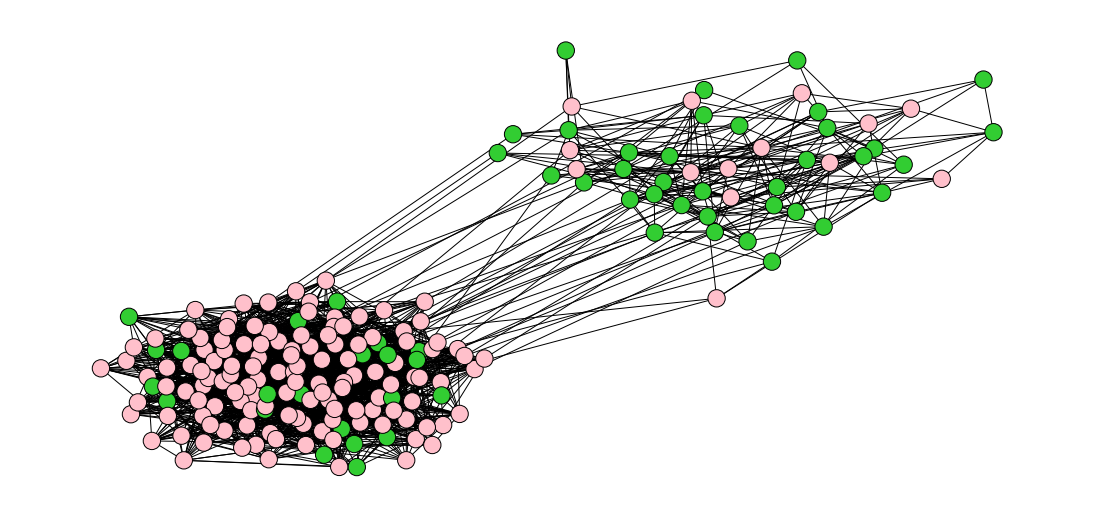

The best iterarion is:  0
Epoch: 000, Loss: 2.4454, Train Acc: 0.0200, Val Acc: 0.2000, Test Acc: 0.2400
Epoch: 001, Loss: 2.2395, Train Acc: 0.2900, Val Acc: 0.2800, Test Acc: 0.2400
The best iterarion is:  2
Epoch: 002, Loss: 2.1407, Train Acc: 0.2400, Val Acc: 0.3200, Test Acc: 0.2800
The best iterarion is:  3
Epoch: 003, Loss: 2.0558, Train Acc: 0.2900, Val Acc: 0.4600, Test Acc: 0.3600
The best iterarion is:  4
Epoch: 004, Loss: 1.9710, Train Acc: 0.4200, Val Acc: 0.7000, Test Acc: 0.5400
The best iterarion is:  5
Epoch: 005, Loss: 1.8812, Train Acc: 0.6200, Val Acc: 0.7200, Test Acc: 0.7200
The best iterarion is:  6
Epoch: 006, Loss: 1.7955, Train Acc: 0.5900, Val Acc: 0.7200, Test Acc: 0.8000
The best iterarion is:  7
Epoch: 007, Loss: 1.7232, Train Acc: 0.7300, Val Acc: 0.7400, Test Acc: 0.8400
Epoch: 008, Loss: 1.6691, Train Acc: 0.6600, Val Acc: 0.7600, Test Acc: 0.8200
Epoch: 009, Loss: 1.6136, Train Acc: 0.7500, Val Acc: 0.7200, Test Acc: 0.7800
Epoch: 010, Loss: 1.5473, Tr

In [38]:
data = datas[3]
print(data)
plt.figure(figsize=(15,7))
# Let's create the cmap based on PiYG, but with other colors
node_colors = []
for i in range(len(data.y)):
    if data.y[i] == 0:
        node_colors.append('pink')
    else:
        node_colors.append('limegreen')
nx.draw(G,
        pos=pos,
        node_color= node_colors,
        edge_color='black',
        width=1,
        style='solid',
        linewidths=1,
        #cmap=plt.cm.PiYG,
        
        #node_size=100,
        with_labels=False,
        alpha=1,
        edgecolors='black'
        
        )
plt.savefig("graph.png",dpi=600)
plt.show()
data.y = torch.tensor(data.y,dtype=torch.long)
data.x = torch.tensor(data.x,dtype=torch.float)
import matplotlib.pyplot as plt
model = ODwire(in_channels=1,
                                hidden_channels=16,
                                num_centers=3,
                                adj_dim = adj.shape[0],
                                n_layers= 10,
                                out_channels=dataset.num_classes).to(device)
criterion = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
test_acc = 0
adjs_in_real_time_supervised = []
embeddings_supervised = []
gnn_out_supervised = []
best_model = None
for epoch in range(300):
    loss,acc_train = train(adj,data,model,train_mask,optimizer,criterion)
    gnn_out_supervised.append(model.gnn_out.detach().cpu().clone().numpy())
    adjs_in_real_time_supervised.append(model.new_adj.detach().cpu().clone().numpy())
    embeddings_supervised.append(model.embeddings.detach().cpu().clone().numpy())
    acc_val = val(adj,data,model,val_mask)
    acc_test = test(adj,data,model,test_mask)
    if acc_test > test_acc:
        test_acc = acc_test
        # We save the model
        best_model = torch.save(model.state_dict(), 'best_model.pth')
        z = model.gnn_out.squeeze(0).detach().cpu()
        print("The best iterarion is: ",epoch)
    # Now let's assign for every node of z the corresponding cluster using kmeans
    from sklearn.cluster import KMeans
    from sklearn.manifold import TSNE
    #kmeans = KMeans(n_clusters=5, random_state=0).fit(z.squeeze(0).detach().cpu().numpy())
    # Let's plot the kmeans over the embedding
    #tsne = TSNE(n_components=2, random_state=123)#,init='pca',learning_rate=200.0)
    #tsne_obj = tsne.fit_transform(z.squeeze(0).detach().cpu().numpy())
    #plt.figure(figsize=(20,10))
    #plt.title('Epoch: {}, Loss: {:.4f}, Train Acc: {:.4f}, Val Acc: {:.4f}, Test Acc: {:.4f}'.format(epoch,loss,acc_train,acc_val,acc_test),fontsize=20)
    #sns.scatterplot(x=tsne_obj[:,0], y=tsne_obj[:,1],s=100,hue=data.y,palette='viridis')
    #plt.show()

    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train Acc: {acc_train:.4f}, Val Acc: {acc_val:.4f}, Test Acc: {acc_test:.4f}')
print('===========================================================================================================')
print('Test Accuracy: ',test_acc)
print('===========================================================================================================')

Los rangos de data.y son:  tensor([0, 1])


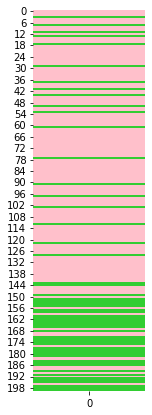

In [48]:
# Let's print the labels of nodes in one column with matplotlib using green or pink
# rangos de data.y
print("Los rangos de data.y son: ",torch.unique(data.y))
# Los que sean 0 les ponemos pink
# Los que sean 1 les ponemos green
data_buena = ['pink' if i == 0 else 'limegreen' for i in data.y]
# Ahora ploteamos una columna con los colores, en vertical y muy ancha
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
cmapa = ListedColormap(['pink', 'limegreen'])
plt.figure(figsize=(2,7))
sns.heatmap(data.y.reshape(-1,1),cmap=cmapa,cbar=False)
plt.show()

Test Accuracy:  0.92
torch.Size([200, 3])
torch.Size([200, 200])
torch.Size([200, 200])
tensor([0.8440, 0.9698, 0.4082])
Autovalores tensor([0.9698, 0.8440, 0.4082])
torch.Size([200, 200])


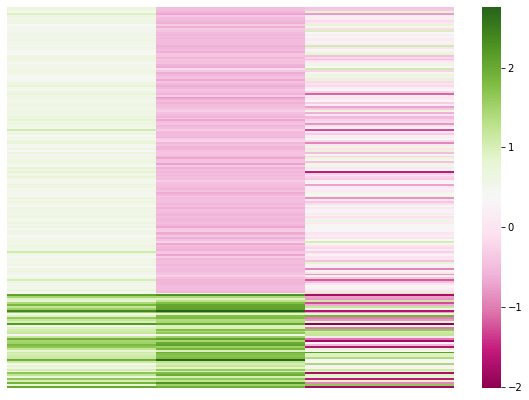

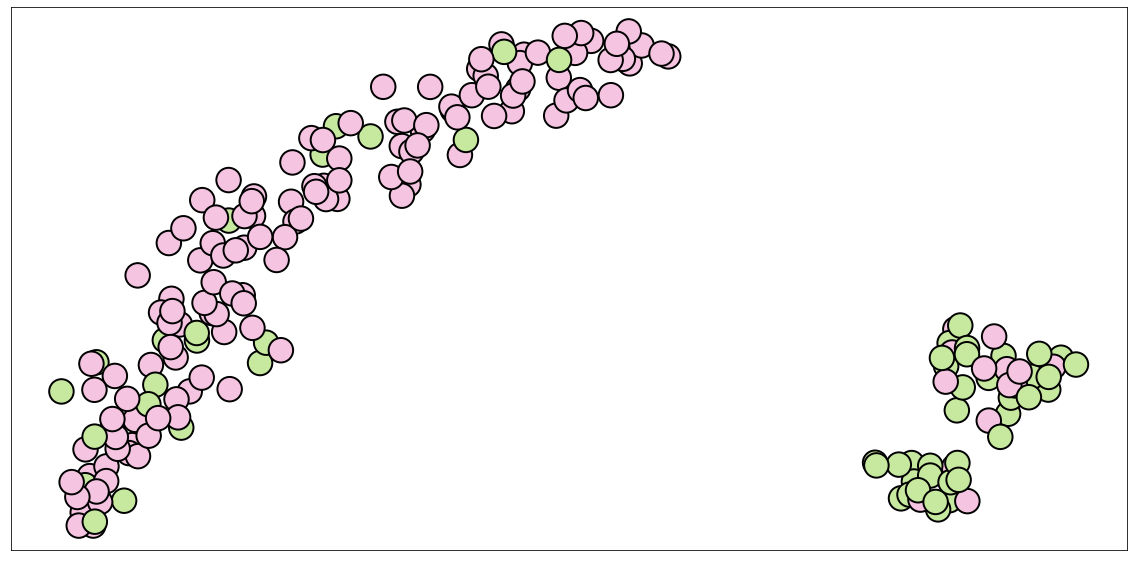

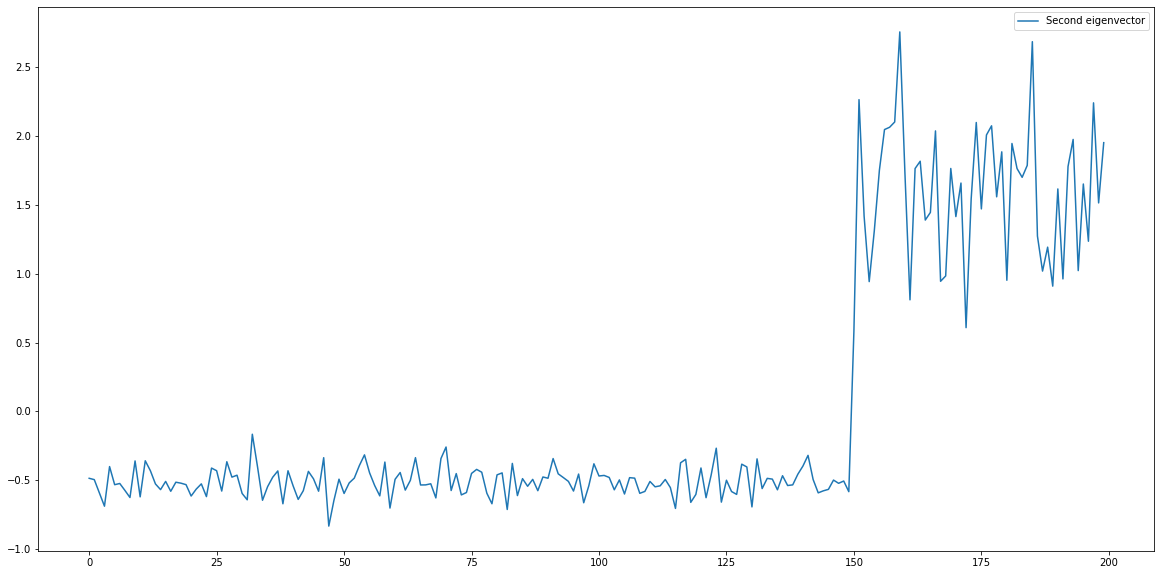

(200, 6)


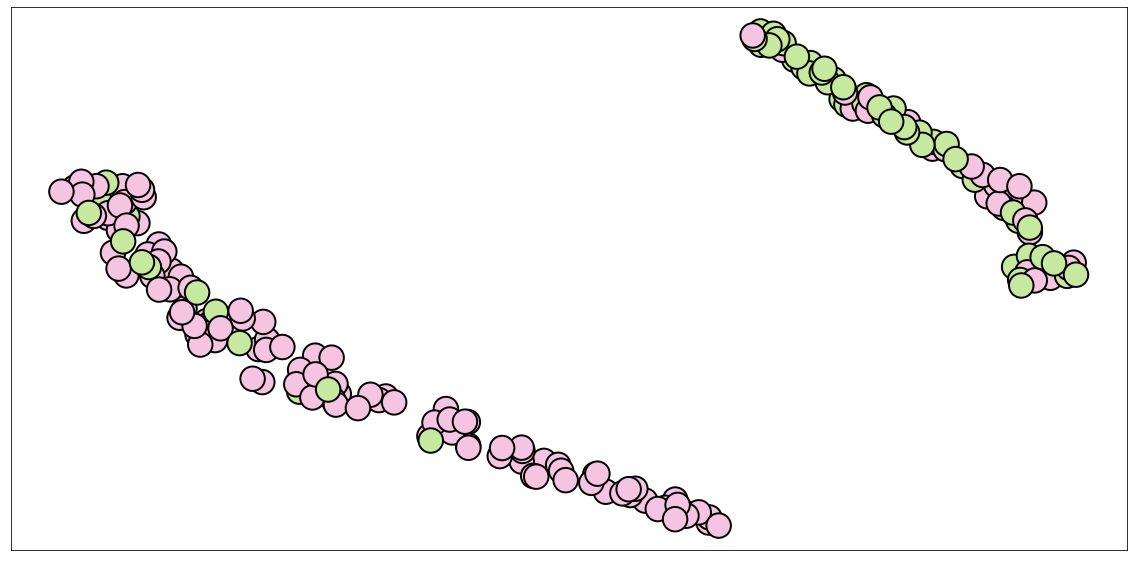

In [354]:
# Leemos el mejor modelo
model.load_state_dict(torch.load('best_model.pth'))
best_model = model
# Le pasamos el mejor modelo a la función de test
acc_test = test(adj,data,best_model,test_mask)
print('===========================================================================================================')
print('Test Accuracy: ',acc_test)
print('===========================================================================================================')
import seaborn as sns
embeddings = best_model.embeddings.squeeze(0).detach().cpu()
print(embeddings.shape)
# Get the degree matrix of adj  
d = torch.sum(adj.squeeze(0), dim=1)
# put it in the diagonal of a matrix
D = torch.diag(d)
print(D.shape)
# Compute the Laplacian
L = D - adj.squeeze(0)
print(L.shape)
# Compute the eigen values
#eign = embeddings.T @ L @ embeddings
CT_num = torch.sum(torch.matmul(torch.matmul(embeddings.transpose(0, 1),adj.squeeze(0)), embeddings), dim=1) # [20, k, N]*[20, N, N]->[20, k, N]*[20, N, k] -> [20] one sum over each graph
CT_den = torch.sum(torch.matmul(torch.matmul(embeddings.transpose(0, 1), D), embeddings), dim=1) # [20, k, N]*[20, N, N]->[20, k, N]*[20, N, k] -> [20] one sum over each graph
print(CT_num/CT_den)    
diagonal_eign = CT_num/CT_den
# Now sort the eigen values
_, indices = torch.sort(diagonal_eign, descending=True)
# Sort the embeddings
embeddings = embeddings[:, indices]
# And the eigen values
diagonal_eign = torch.sort(diagonal_eign, descending=True)[0]
print("Autovalores",diagonal_eign)
print(L.shape)
plt.figure(figsize=(10,7))
sns.heatmap(embeddings.numpy(), cmap='PiYG',xticklabels=False,yticklabels=False)
# Don't show the legend
plt.legend([],[], frameon=False)
# Dont show the colorbar in the heatmap
plt.show()
z = best_model.embeddings.squeeze(0).detach().cpu()
# Now let's assign for every node of z the corresponding cluster using kmeans
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
#kmeans = KMeans(n_clusters=5, random_state=0).fit(z.squeeze(0).detach().cpu().numpy())
# Let's plot the kmeans over the embedding
tsne = TSNE(n_components=2, random_state=42,init='pca',learning_rate=200.0)
tsne_obj = tsne.fit_transform(z.squeeze(0).detach().cpu().numpy())
plt.figure(figsize=(20,10))
sns.scatterplot(x=tsne_obj[:,0], y=tsne_obj[:,1],s=600,hue=data.y,palette='PiYG',edgecolor='black',alpha=1)
# Quitamos los ejes
plt.xticks([])
plt.yticks([])
# Quitamos la leyenda
plt.legend([],[], frameon=False)
#plt.savefig("embeddings.png",dpi=600)
plt.show()
# Let's get the second and third eigenvector
second_eigenvector = embeddings[:,1]
#third_eigenvector = embeddings[:,2]
# Now let's asume they are functions and let's plot them
plt.figure(figsize=(20,10))
plt.plot(second_eigenvector.detach().cpu().numpy(),label='Second eigenvector')
#plt.plot(third_eigenvector.detach().cpu().numpy(),label='Third eigenvector')
plt.legend()
plt.show()
gnn_out_supervised = best_model.gnn_out.squeeze(0).detach().cpu().numpy()
print(gnn_out_supervised.shape)
plt.figure(figsize=(20,10))
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, perplexity=15, learning_rate=12, n_iter=1000)
tsne_obj = tsne.fit_transform(gnn_out_supervised)
# Intercambiamos los siguientes nodos:
# 58 -> 32
#tsne_obj[58],tsne_obj[32] = tsne_obj[32],tsne_obj[58]
# 32 -> 52
#tsne_obj[32],tsne_obj[52] = tsne_obj[52],tsne_obj[32]
# 13 -> 35
#tsne_obj[13],tsne_obj[35] = tsne_obj[35],tsne_obj[13]
# 52 -> 31
#tsne_obj[52],tsne_obj[31] = tsne_obj[31],tsne_obj[52]
# Con puntos más grandes y con bordes más oscuros
sns.scatterplot(x=tsne_obj[:,0], y=tsne_obj[:,1],s=600,hue=data.y,palette='PiYG',edgecolor='black',alpha=1)
plt.xticks([])
plt.yticks([])
plt.legend([],[], frameon=False)
#plt.savefig("gnn_out.png",dpi=600)
plt.show()
embeddings = best_model.embeddings.squeeze(0).detach().cpu()
cdist = torch.cdist(embeddings,embeddings,p=2)
exp_cdist = torch.exp(-cdist)
# Plot it in 3D using matplotlib
import plotly.graph_objects as go
from plotly.offline import iplot
import scipy.ndimage
sigma = [2.5, 2.5]
depth_smooth = scipy.ndimage.filters.gaussian_filter(exp_cdist, sigma)
fig = go.Figure(data=[go.Surface(z=depth_smooth)])
fig.update_layout(title='Smoothed adjacency matrix', autosize=False,
                   width=500, height=500,
                    margin=dict(l=65, r=50, b=65, t=90))    
fig.update_layout(title=None, autosize=False,

                       width=500, height=500,
                        margin=dict(l=65, r=50, b=65, t=90))
# No mostramos los ejes
fig.update_layout(scene = dict( xaxis = dict(title='',showticklabels=False),
                               yaxis = dict(title='',showticklabels=False),
                                zaxis = dict(title='',showticklabels=False)))
# No mostramos el fondo
fig.update_layout(scene = dict(
                    xaxis = dict(showbackground=False),
                    yaxis = dict(showbackground=False),
                    zaxis = dict(showbackground=False)))
# Cambiamos el heatmap
fig.update_traces(contours_z=dict(show=False, usecolormap=True,
                                    highlightcolor="limegreen", project_z=True))
# Mostramos el countour
fig.update_traces(contours_z=dict(show=True, usecolormap=True,
                                   highlightcolor="limegreen", project_z=True))

# Cambiamos el mapa de colores
fig.update_traces(colorscale='Bluered')
# No mostramos el colorbar
fig.update_layout(coloraxis_showscale=False)
# Cambiamos la orientacion de la camara para verlo desde arriba y un poco de lado
fig.update_layout(scene_camera=dict(eye=dict(x=-1.25, y=-1.25, z=1.25)))
fig.update_layout(coloraxis_showscale=False)
# Ocultamos la colorbar
fig.update_layout(coloraxis_showscale=False)
fig.update(layout_showlegend=False)
fig.update(layout_coloraxis_showscale=False)
fig.update_traces(showscale=False)
config = {
'toImageButtonOptions': {
'format': 'png', # one of png, svg, jpeg, webp
'filename': 'custom_image',
'width': 700,
'height': 500,
'scale':6 # Multiply title/legend/axis/canvas sizes by this factor
}
}
# Mostramos las coordenadas de las prespectivas en el fig.show

fig.show(config=config)

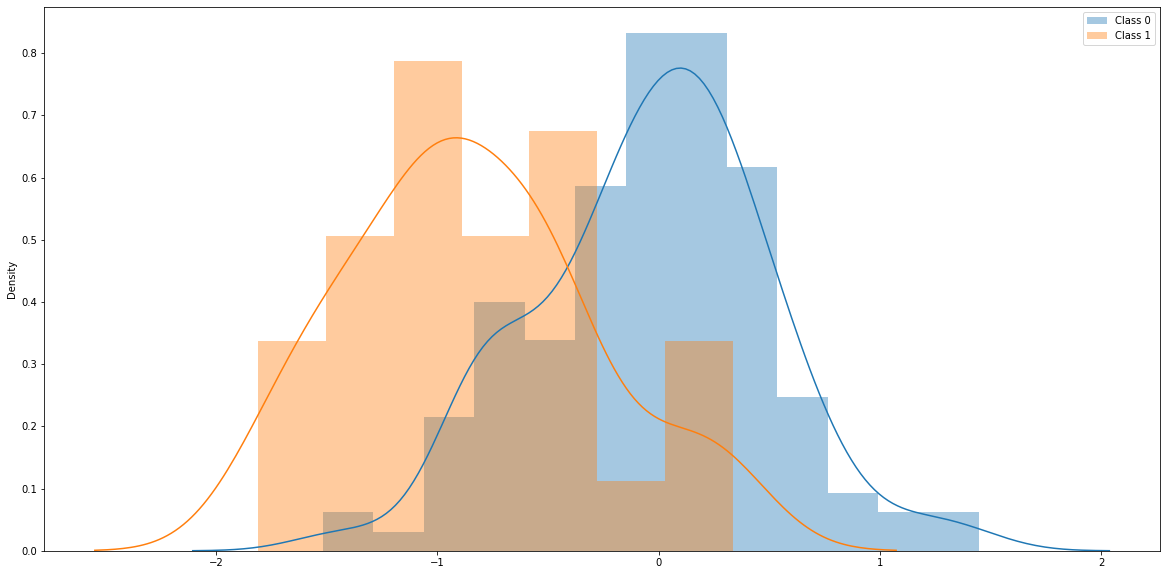

(200, 6)


In [342]:
# Now let's plot the distribution of the features of class 0 and class 1
plt.figure(figsize=(20,10))
sns.distplot(data.x[data.y==0].detach().cpu().numpy(),label='Class 0')
sns.distplot(data.x[data.y==1].detach().cpu().numpy(),label='Class 1')
plt.legend()
plt.show()
# Features after applying the pum
print(gnn_out_supervised.shape)

[2.49800181e-16 7.87755790e-02]
[[ 0.07072929 -0.02748627]
 [ 0.07256672 -0.02802853]
 [ 0.0827388  -0.03244191]
 [ 0.09034484 -0.03513484]
 [ 0.07610862 -0.01853329]
 [ 0.07949286 -0.03218935]
 [ 0.07610862 -0.02887886]
 [ 0.07781914 -0.03060774]
 [ 0.09179045 -0.03636917]
 [ 0.06284463 -0.0255656 ]
 [ 0.07949286 -0.03378043]
 [ 0.06490565 -0.02495775]
 [ 0.07781914 -0.02016993]
 [ 0.07435876 -0.02742284]
 [ 0.08738191 -0.03240067]
 [ 0.07072929 -0.02799634]
 [ 0.08431491 -0.03277083]
 [ 0.08113206 -0.01986196]
 [ 0.07610862 -0.03098875]
 [ 0.07610862 -0.03054111]
 [ 0.0827388  -0.03379919]
 [ 0.07781914 -0.03188935]
 [ 0.07610862 -0.02798752]
 [ 0.07435876 -0.02914126]
 [ 0.06490565 -0.02696965]
 [ 0.07256672 -0.02744626]
 [ 0.0827388  -0.03358024]
 [ 0.06884284 -0.00474103]
 [ 0.07949286 -0.03059883]
 [ 0.07072929 -0.02572995]
 [ 0.08113206 -0.03146051]
 [ 0.07610862 -0.0303197 ]
 [ 0.07072929 -0.00410577]
 [ 0.06884284 -0.0275551 ]
 [ 0.08431491 -0.03123669]
 [ 0.08431491 -0.034037

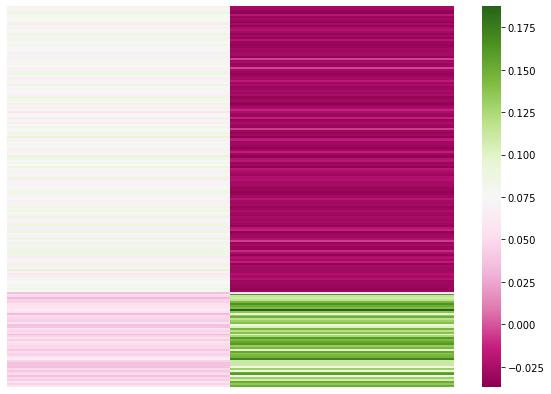

In [343]:
adj = to_dense_adj(data.edge_index)[0].to(device)
# Let's get the eigenvectors of the Laplacian
g_mala = nx.from_numpy_matrix(adj.squeeze(0).detach().cpu().numpy())
L = nx.normalized_laplacian_matrix(g_mala).todense()
eigenvalues, eigenvectors = np.linalg.eig(L)
eigenvalues = np.sort(eigenvalues)
eigenvectors = eigenvectors[:, eigenvalues.argsort()]
eigenvalues = eigenvalues[eigenvalues.argsort()]
# Obtenemos los dos primeros eigenvectores
eigenvalues = eigenvalues[:2]
eigenvectors = eigenvectors[:,:2]
print(eigenvalues)
print(eigenvectors)
plt.figure(figsize=(10,7))
sns.heatmap(eigenvectors, cmap='PiYG',xticklabels=False,yticklabels=False)
# Don't show the legend
plt.legend([],[], frameon=False)
# Dont show the colorbar in the heatmap
plt.show()


In [344]:
embeddings = torch.tensor(eigenvectors)
cdist = torch.cdist(embeddings,embeddings,p=2)
exp_cdist = torch.exp(-cdist)
# Plot it in 3D using matplotlib
import plotly.graph_objects as go
from plotly.offline import iplot
import scipy.ndimage
sigma = [2.5, 2.5]
depth_smooth = scipy.ndimage.filters.gaussian_filter(exp_cdist, sigma)
fig = go.Figure(data=[go.Surface(z=depth_smooth)])
fig.update_layout(title='Smoothed adjacency matrix', autosize=False,
                   width=500, height=500,
                    margin=dict(l=65, r=50, b=65, t=90))    
fig.update_layout(title=None, autosize=False,

                       width=500, height=500,
                        margin=dict(l=65, r=50, b=65, t=90))
# No mostramos los ejes
fig.update_layout(scene = dict( xaxis = dict(title='',showticklabels=False),
                               yaxis = dict(title='',showticklabels=False),
                                zaxis = dict(title='',showticklabels=False)))
# No mostramos el fondo
fig.update_layout(scene = dict(
                    xaxis = dict(showbackground=False),
                    yaxis = dict(showbackground=False),
                    zaxis = dict(showbackground=False)))
# Cambiamos el heatmap
fig.update_traces(contours_z=dict(show=False, usecolormap=True,
                                    highlightcolor="limegreen", project_z=True))
# Mostramos el countour
fig.update_traces(contours_z=dict(show=True, usecolormap=True,
                                   highlightcolor="limegreen", project_z=True))

# Cambiamos el mapa de colores
fig.update_traces(colorscale='Bluered')
# No mostramos el colorbar
fig.update_layout(coloraxis_showscale=False)
# Cambiamos la orientacion de la camara para verlo desde arriba y un poco de lado
fig.update_layout(scene_camera=dict(eye=dict(x=-1.25, y=-1.25, z=1.25)))
fig.update_layout(coloraxis_showscale=False)
# Ocultamos la colorbar
fig.update_layout(coloraxis_showscale=False)
fig.update(layout_showlegend=False)
fig.update(layout_coloraxis_showscale=False)
fig.update_traces(showscale=False)
config = {
'toImageButtonOptions': {
'format': 'png', # one of png, svg, jpeg, webp
'filename': 'custom_image',
'width': 700,
'height': 500,
'scale':6 # Multiply title/legend/axis/canvas sizes by this factor
}
}
# Mostramos las coordenadas de las prespectivas en el fig.show

fig.show(config=config)